In [1]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

import pandas as pd

# Definition of data

In [2]:
N = 6 # Number of generators
T = 24 # Time periods

generation_costs = np.array([15, 20, 15, 20, 30, 25.])
capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

In [3]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 1.1

In [75]:
# Define variables
g = cp.Variable((T, N))

In [76]:
# Define objective
obj = cp.Minimize(sum(generation_costs@g.T))

In [77]:
# Define Constraints

# Non-neg constraints
cons = [g >= 0]

# First time period
cons.append( sum(g[0,:]) + rt[0] == dt[0])

# For the next T-1 periods
for t in range(1, T):
    cons.append( sum(g[t,:]) + rt[t] == dt[t]) # Demand is met
    cons.append( g[t,:] - g[t-1,:] <= ramp_up_rate) # Ramp up cons
    cons.append( g[t-1,:] - g[t,:] <= ramp_down_rate) # Ramp down cons

# For all the generators    
for n in range(N):
    cons.append(g[:, n] <= capacity[n]) # Capacity cons

In [78]:
# Solve
problem = cp.Problem(obj, cons)
problem.solve()

10158.499999992244

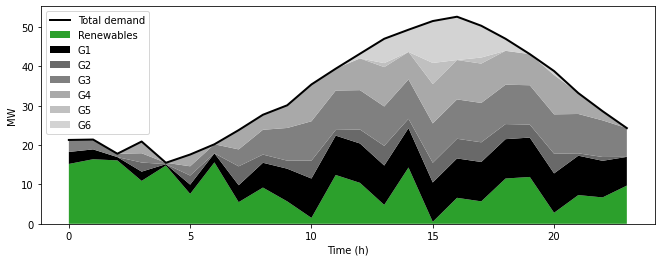

In [82]:
# Plot results
df = pd.DataFrame(abs(g.value), columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
df.insert(0, 'Renewables', rt)

# Color palette
colors = ['tab:green', 'black', 'dimgray', 'gray', 'darkgrey', 'silver', 'lightgray']

# Plot results
fig, ax = plt.subplots(figsize = (11, 4))
ax.stackplot(np.arange(T), df.T, labels= df.columns, colors = colors)
plt.plot(dt, linewidth=2, c = 'k', label = 'Total demand')
plt.ylabel('MW')
plt.xlabel('Time (h)')
plt.legend()


# Question 1.2

In [45]:
# Define parameters
nu_d = 0.92
nu_c = 0.95
S_bar = 20

In [46]:
# Define variables
g = cp.Variable((T, N)) # Generator output
bc = cp.Variable((T, 1)) # Battery charge
bd = cp.Variable((T, 1)) # Battery discharged
S = cp.Variable((T+1, 1)) # Battery status

In [47]:
# Define objective
obj = cp.Minimize(sum(generation_costs@g.T))

In [48]:
# Define Constraints
cons = [g >= 0]

cons.append( sum(g[0,:]) + rt[0] + bd[0] == dt[0] + bc[0])

cons.append(S >= 0)

cons.append(bc >= 0)
cons.append(bd >= 0)

cons.append(S <= S_bar)

cons.append(S[0] == 0)

cons.append(S[1] == S[0] + bc[0] - bd[0])

cons.append(S[-1] == 0)

for t in range(1, T):
    cons.append(S[t + 1] == S[t] + bc[t] - bd[t])
    cons.append( sum(g[t,:]) + rt[t] + bd[t] == dt[t] + bc[t])
    cons.append( g[t,:] - g[t-1,:] <= ramp_up_rate)
    cons.append( g[t-1,:] - g[t,:] <= ramp_down_rate)

for n in range(N):
    cons.append(g[:, n] <= capacity[n])

In [49]:
# Get results
# Solve
problem = cp.Problem(obj, cons)
problem.solve()

9719.000000156624

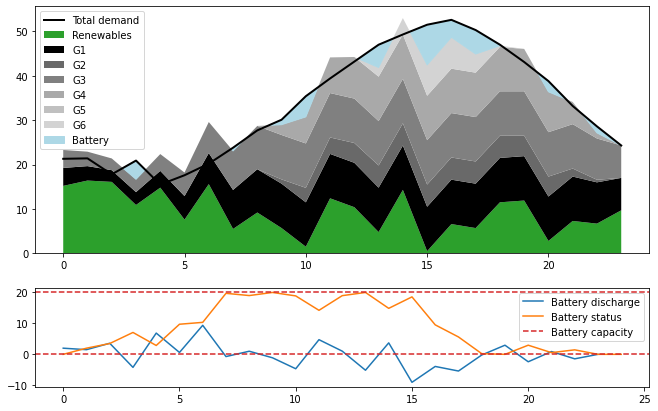

In [73]:
# Plot results
df = pd.DataFrame(abs(g.value), columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
df.insert(0, 'Renewables', rt)
#df['Battery'] = np.maximum(bd.value- bc.value, 0)


fig, ax = plt.subplots(2, 1, figsize = (11, 7), gridspec_kw={'height_ratios': [2.5, 1]})
#df.plot.area(ax = ax[0])
ax[0].stackplot(np.arange(T), df.T, labels = df.columns, colors = colors)
ax[0].plot(dt, linewidth=2, c = 'k', label = 'Total demand')
ax[0].fill_between(np.arange(24), df.sum(axis = 1),dt,  where = (dt >= df.sum(axis = 1)), label = 'Battery',
                   color = 'lightblue', interpolate = True)
#ax[0].plot(np.arange(T)[df.sum(axis = 1) >= dt], df.sum(axis = 1)[df.sum(axis = 1) >= dt], c = 'purple')
ax[0].legend()

ax[1].plot(bc.value - bd.value, label = 'Battery discharge')
ax[1].plot(S.value, label = 'Battery status')
ax[1].axhline(20, linestyle = '--', c = 'tab:red', label = 'Battery capacity')
ax[1].axhline(0, linestyle = '--', c = 'tab:red')

ax[1].legend()
